In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import warnings
import tensorflow as tf
from sklearn.decomposition import TruncatedSVD
warnings.filterwarnings('ignore')

# Препроцесс и описательная статитстика

all_posts_v1.csv - спаршенные данные по 4 группам тематики метро

In [18]:

df_raw = pd.read_csv('../data/raw/all_posts_v1.csv')

In [19]:
print(f"📊 Размер датасета: {df_raw.shape[0]} строк, {df_raw.shape[1]} колонок")
print("\n📝 Типы данных:")
print(df_raw.dtypes)

📊 Размер датасета: 72152 строк, 11 колонок

📝 Типы данных:
post_id               object
group_name            object
group_display_name    object
text                  object
comments_count         int64
likes                  int64
reposts                int64
views                  int64
date                  object
url                   object
text_length            int64
dtype: object


In [20]:
df_raw['group_name']

0           mosmetro
1           mosmetro
2           mosmetro
3           mosmetro
4           mosmetro
            ...     
72147    gazetametro
72148    gazetametro
72149    gazetametro
72150    gazetametro
72151    gazetametro
Name: group_name, Length: 72152, dtype: object

Анализ всех групп

In [21]:

group_analysis = df_raw.groupby('group_name').agg({
    'comments_count': ['count', 'sum', 'mean', 'std', 'min', 'max'],
    'likes': ['mean'],
    'views': ['mean'],
    'text_length': ['mean']
}).round(2)

 
group_analysis.columns = [
    'posts_count', 'comments_total', 'comments_mean', 'comments_std', 
    'comments_min', 'comments_max', 'likes_mean', 'views_mean', 'text_length_mean'
]

print("📈 СТАТИСТИКА ПО ГРУППАМ:")
print(group_analysis.sort_values('posts_count', ascending=False))

📈 СТАТИСТИКА ПО ГРУППАМ:
             posts_count  comments_total  comments_mean  comments_std  \
group_name                                                              
moscowmetro        40958          384319           9.38         15.01   
gazetametro        16026           34938           2.18         13.25   
mosmetro            7937          272011          34.27        141.28   
mirmetro            7231           59280           8.20         24.20   

             comments_min  comments_max  likes_mean  views_mean  \
group_name                                                        
moscowmetro             0          1477        9.13      267.83   
gazetametro             0           620       25.94     3059.32   
mosmetro                0         10749      182.99    12346.61   
mirmetro                0          1443      113.54     4355.73   

             text_length_mean  
group_name                     
moscowmetro            292.14  
gazetametro            555.24  
mosme

Не смотря на то что группа moscowmetro имеет максимальное количество постов и комментирев,при дальнейшем анализе активности последних 8 лет,большинство из них нулевые( то есть пост не содержит текста),к тому же в этой группе 384к коментов на 40к постов, мы берем mosmetro тк эта группа имеет наибольшее количество ненулевых постов и имеет соотношение 272к коментариев на 8к постов 

In [23]:
df_mosmetro = df_raw[df_raw['group_name'] == 'mosmetro'].copy()

print("📊 АНАЛИЗ ГРУППЫ MOSCOWMETRO:")
print("=" * 50)
print(f"📝 Всего постов: {len(df_mosmetro)}")
print(f"💬 Всего комментариев: {df_mosmetro['comments_count'].sum()}")
print(f"📅 Период данных: {df_mosmetro['date'].min()} - {df_mosmetro['date'].max()}")

📊 АНАЛИЗ ГРУППЫ MOSCOWMETRO:
📝 Всего постов: 7937
💬 Всего комментариев: 272011
📅 Период данных: 2014-04-20 13:04:22 - 2025-11-05 09:30:00


In [24]:
# Преобразуем дату и извлекаем компоненты времени
df_mosmetro['date'] = pd.to_datetime(df_mosmetro['date'])
df_mosmetro['year'] = df_mosmetro['date'].dt.year
df_mosmetro['month'] = df_mosmetro['date'].dt.month
df_mosmetro['year_month'] = df_mosmetro['date'].dt.to_period('M')

# Анализ по годам
print("\n📈 РАСПРЕДЕЛЕНИЕ ПО ГОДАМ:")
yearly_stats = df_mosmetro.groupby('year').agg({
    'comments_count': ['count', 'sum', 'mean'],
    'likes': ['mean'],
    'views': ['mean']
}).round(2)

yearly_stats.columns = ['posts', 'comments_total', 'comments_mean', 'likes_mean', 'views_mean']
print(yearly_stats)


📈 РАСПРЕДЕЛЕНИЕ ПО ГОДАМ:
      posts  comments_total  comments_mean  likes_mean  views_mean
year                                                              
2014   1043            6533           6.26       20.27        0.00
2015    510            8542          16.75       56.27        0.00
2016    479           10754          22.45       98.18        0.00
2017    809           23677          29.27      141.54    11620.43
2018    367           14322          39.02      179.49    16483.36
2019    426           22032          51.72      255.74    20646.98
2020    468           26732          57.12      339.36    21658.15
2021    378           17048          45.10      303.79    15838.87
2022    686           30769          44.85      263.50    18194.02
2023    932           48133          51.64      293.00    20691.85
2024   1033           32393          31.36      195.20    12414.04
2025    806           31076          38.56      170.09    16174.22


В 2017 году среднее количество комментариев на пост (29.27) выросло в 1.7 раза по сравнению с 2016 годом (22.45), а средние лайки подскочили с 98.18 до 141.54 (+44%).
тк поведение пользователей 2014-2016 года слабо коррелирует с современными привычками, мы сфокусируемся на периоде 2017-2025.

Данные за эти года вполне релевантны для прогнозирования будущего поведения.

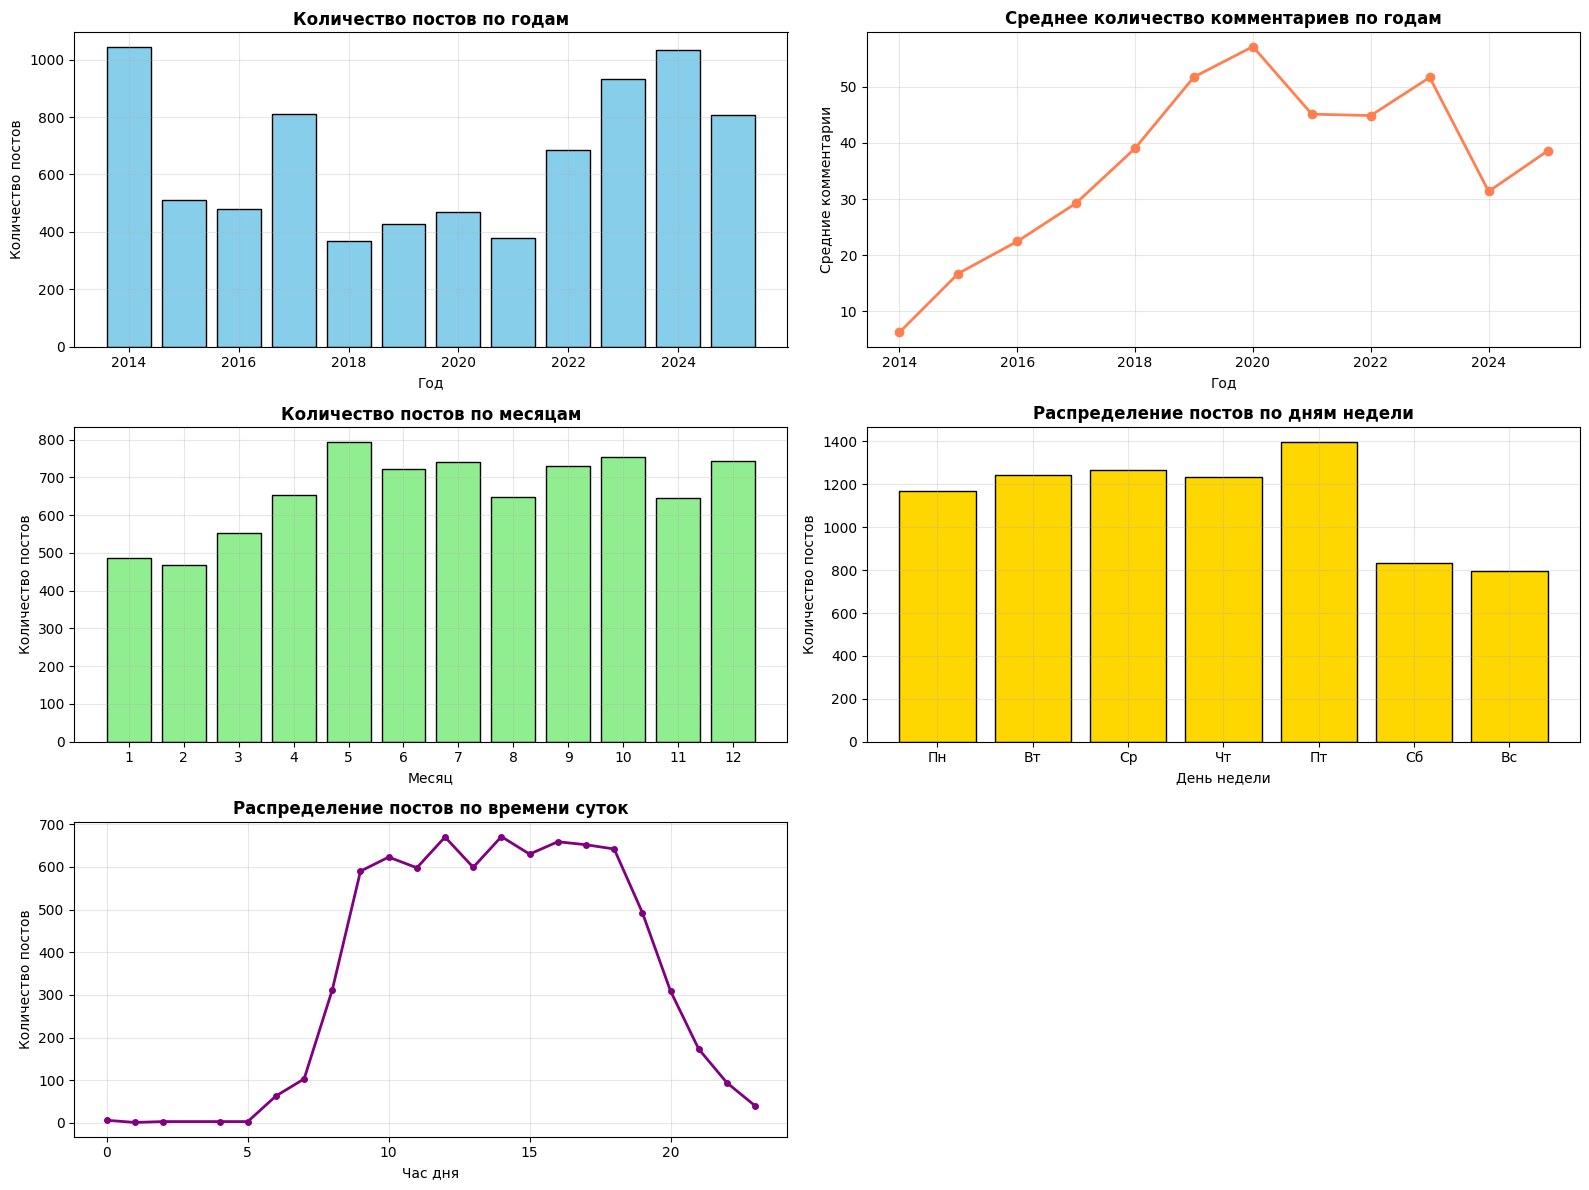

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 12))

# 1. Распределение постов по годам
plt.subplot(3, 2, 1)
posts_by_year = df_mosmetro['year'].value_counts().sort_index()
plt.bar(posts_by_year.index, posts_by_year.values, color='skyblue', edgecolor='black')
plt.title('Количество постов по годам', fontweight='bold', fontsize=12)
plt.xlabel('Год')
plt.ylabel('Количество постов')
plt.grid(True, alpha=0.3)

# 2. Средние комментарии по годам
plt.subplot(3, 2, 2)
mean_comments_year = df_mosmetro.groupby('year')['comments_count'].mean()
plt.plot(mean_comments_year.index, mean_comments_year.values, 'o-', linewidth=2, markersize=6, color='coral')
plt.title('Среднее количество комментариев по годам', fontweight='bold', fontsize=12)
plt.xlabel('Год')
plt.ylabel('Средние комментарии')
plt.grid(True, alpha=0.3)

# 3. Распределение по месяцам (все годы вместе)
plt.subplot(3, 2, 3)
posts_by_month = df_mosmetro['month'].value_counts().sort_index()
plt.bar(posts_by_month.index, posts_by_month.values, color='lightgreen', edgecolor='black')
plt.title('Количество постов по месяцам', fontweight='bold', fontsize=12)
plt.xlabel('Месяц')
plt.ylabel('Количество постов')
plt.xticks(range(1, 13))
plt.grid(True, alpha=0.3)

# 4. Активность по дням недели
plt.subplot(3, 2, 4)
df_mosmetro['day_of_week'] = df_mosmetro['date'].dt.dayofweek
days_count = df_mosmetro['day_of_week'].value_counts().sort_index()
day_names = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
plt.bar(day_names, days_count.values, color='gold', edgecolor='black')
plt.title('Распределение постов по дням недели', fontweight='bold', fontsize=12)
plt.xlabel('День недели')
plt.ylabel('Количество постов')
plt.grid(True, alpha=0.3)

# 5. Распределение по часам публикации
plt.subplot(3, 2, 5)
df_mosmetro['hour'] = df_mosmetro['date'].dt.hour
hourly_count = df_mosmetro['hour'].value_counts().sort_index()
plt.plot(hourly_count.index, hourly_count.values, 'o-', linewidth=2, markersize=4, color='purple')
plt.title('Распределение постов по времени суток', fontweight='bold', fontsize=12)
plt.xlabel('Час дня')
plt.ylabel('Количество постов')
plt.grid(True, alpha=0.3)



plt.tight_layout()
plt.show()

In [25]:

selected_years = [2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024,2025]
df_selected = df_mosmetro[df_mosmetro['year'].isin(selected_years)]

print(f"• Годы: {selected_years}")
print(f"• Постов: {len(df_selected)} ({len(df_selected)/len(df_mosmetro)*100:.1f}% от всех данных)")
print(f"• Комментариев: {df_selected['comments_count'].sum()}")
print(f"• Средние комментарии: {df_selected['comments_count'].mean():.2f}")


• Годы: [2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
• Постов: 5905 (74.4% от всех данных)
• Комментариев: 246182
• Средние комментарии: 41.69


In [13]:
# Анализ дубликатов
print("\n🔁 ДУБЛИКАТЫ:")
print(f"Полные дубликаты строк: {df_selected.duplicated().sum()}")
print(f"Дубликаты по тексту постов: {df_selected['text'].duplicated().sum()}")
print(f"Дубликаты по ID постов: {df_selected['post_id'].duplicated().sum()}")


🔁 ДУБЛИКАТЫ:
Полные дубликаты строк: 0
Дубликаты по тексту постов: 311
Дубликаты по ID постов: 0


In [14]:
original_size = len(df_selected)
df = df_selected.copy()
 
df_clean = df.drop_duplicates(subset=['text'], keep='first')
duplicates_removed = original_size - len(df_clean)
print(f"   Удалено дубликатов текста: {duplicates_removed}")

   Удалено дубликатов текста: 311


In [15]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5594 entries, 0 to 5904
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   post_id             5594 non-null   object        
 1   group_name          5594 non-null   object        
 2   group_display_name  5594 non-null   object        
 3   text                5594 non-null   object        
 4   comments_count      5594 non-null   int64         
 5   likes               5594 non-null   int64         
 6   reposts             5594 non-null   int64         
 7   views               5594 non-null   int64         
 8   date                5594 non-null   datetime64[ns]
 9   url                 5594 non-null   object        
 10  text_length         5594 non-null   int64         
 11  year                5594 non-null   int32         
 12  month               5594 non-null   int32         
 13  year_month          5594 non-null   period[M]     
dt

In [16]:
df_clean.describe()

,comments_count,likes,reposts,views,date,text_length,year,month
count,5594.000000,5594.000000,5594.000000,5.594000e+03,5594,5594.000000,5594.000000,5594.000000
mean,42.668037,220.265105,25.702002,1.649915e+04,2022-02-17 05:30:53.671254784,463.492849,2021.623346,6.596711
min,0.000000,27.000000,0.000000,1.060000e+03,2017-01-01 11:42:07,1.000000,2017.000000,1.000000
25%,9.000000,104.000000,6.000000,9.625000e+03,2019-08-20 20:18:51.500000,244.250000,2019.000000,4.000000
50%,22.000000,163.000000,12.000000,1.311850e+04,2022-12-14 02:08:47.500000,419.000000,2022.000000,7.000000
75%,45.000000,265.000000,25.000000,1.811225e+04,2024-06-28 16:07:45.750000128,617.000000,2024.000000,9.000000
max,10749.000000,4057.000000,835.000000,1.543454e+06,2025-11-05 09:30:00,4076.000000,2025.000000,12.000000
std,167.147440,200.803927,49.584932,2.847689e+04,NaN,318.954859,2.732335,3.322527


In [17]:
df_clean= df_clean[
    (df_clean['views'] > 1) &  # больше 1 просмотра
    (df_clean['text_length'] >=1)  # хотя бы 1 символ
]

In [18]:
df_clean.shape

(5594, 14)

In [ ]:
keep_columns = [
    'text',            
    'comments_count'  
]
df_clean= df_clean[keep_columns].copy()
df_clean.head()

,text,comments_count
0,🍂 Осень — лучшее время для горячего чая и люби...,0
1,📲 Мы достигли лучших значений по стабильности ...,8
2,🎵 Концерт артистов проекта «Музыка в метро» пр...,0
3,Строить маршруты стало удобнее: мы добавили оп...,20
4,💍 100-я пара заключила брак на станции метро «...,105


In [20]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5594 entries, 0 to 5904
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            5594 non-null   object
 1   comments_count  5594 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 131.1+ KB


In [21]:
print("🎯 ФИНАЛЬНЫЙ ДАТАСЕТ MOSMETRO:")
print(f"📝 Постов: {len(df_clean)}")
print(f"💬 Комментариев всего: {df_clean['comments_count'].sum()}")
print(f"📈 Средние комментарии: {df_clean['comments_count'].mean():.2f}")
 
print(f"\n📊 РАСПРЕДЕЛЕНИЕ КОММЕНТАРИЕВ:")
print(df_clean['comments_count'].describe())
 
print(f"\n🔍 ДИАПАЗОН КОММЕНТАРИЕВ:")
print(f"• Мин: {df_clean['comments_count'].min()}")
print(f"• Макс: {df_clean['comments_count'].max()}")
print(f"• Медиана: {df_clean['comments_count'].median()}")

🎯 ФИНАЛЬНЫЙ ДАТАСЕТ MOSMETRO:
📝 Постов: 5594
💬 Комментариев всего: 238685
📈 Средние комментарии: 42.67

📊 РАСПРЕДЕЛЕНИЕ КОММЕНТАРИЕВ:
count     5594.000000
mean        42.668037
std        167.147440
min          0.000000
25%          9.000000
50%         22.000000
75%         45.000000
max      10749.000000
Name: comments_count, dtype: float64

🔍 ДИАПАЗОН КОММЕНТАРИЕВ:
• Мин: 0
• Макс: 10749
• Медиана: 22.0


(ограничение) выбросов - заменяем на 95%


In [ ]:
# Вычисляем пороговое значение (95-й перцентиль)
percentile_95 = df_clean['comments_count'].quantile(0.95)
 
df_capped = df_clean.copy()

# Заменяем значения выше перцентиля на значение перцентиля
df_capped['comments_count'] = np.where(
    df_capped['comments_count'] > percentile_95,
    percentile_95,
    df_capped['comments_count']
)

print(f"• Максимум ДО: {df_clean['comments_count'].max()}")
print(f"• Максимум ПОСЛЕ: {df_capped['comments_count'].max()}")
print(f"• Значение 95% перцентиля: {percentile_95:.2f}")

• Максимум ДО: 10749
• Максимум ПОСЛЕ: 125.0
• Значение 95% перцентиля: 125.00


In [23]:
df_capped 

,text,comments_count
0,🍂 Осень — лучшее время для горячего чая и люби...,0.0
1,📲 Мы достигли лучших значений по стабильности ...,8.0
2,🎵 Концерт артистов проекта «Музыка в метро» пр...,0.0
3,Строить маршруты стало удобнее: мы добавили оп...,20.0
4,💍 100-я пара заключила брак на станции метро «...,105.0
...,...,...
5900,С Новым годом!\n \n/Скульптура «Пионерки с гло...,1.0
5901,Площадки проведения фестиваля «Путешествие в Р...,4.0
5902,График работы Новогоднего поезда #мосметро 1 и...,5.0
5903,"С Новым годом, друзья! :)\n\n/Скульптура «Птич...",12.0


In [24]:

df_path = '../data/raw/df_mosmetro_sample.csv'
df_capped.to_csv(df_path, index=False, encoding='utf-8')
print("Сохранено") 

Сохранено


df_mosmetro_sample

5594 rows × 2 columns

Максимум: 125.0
Значение 95% перцентиля: 125.00

## Создаем версии данных для экспериментов:

Регрессия (чистый текст)

# Предобработка текста для NLP

In [28]:
df_exp1 = df= pd.read_csv('../data/raw/df_mosmetro_sample.csv')

In [29]:
df_exp1.shape

(5594, 2)

In [30]:
df_exp1.describe()

,comments_count
count,5594.000000
mean,33.509653
std,33.387779
min,0.000000
25%,9.000000
50%,22.000000
75%,45.000000
max,125.000000


*   Приведение к нижнему регистру: Преобразуйте все слова в нижний регистр.
*   Удаление знаков пунктуации и специальных символов.
*   Удаление стоп-слов: Используйте список стоп-слов для русского языка для удаления часто встречающихся, но не несущих важную информацию для анализа слов.
*   Лемматизация: приведите слова к нормальной форме

In [32]:
import pymorphy3
import re 
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm.auto import tqdm
import nltk
nltk.download('stopwords')
morph = pymorphy3.MorphAnalyzer()
def preprocess_text(text):
    """
    Предобработка текста: приведение к нижнему регистру, удаление пунктуации,
    стоп-слов и лемматизация
    """
    # Проверка на пустой текст
    if not isinstance(text, str) or not text.strip():
        return ""
    
    # Приведение к нижнему регистру
    text = text.lower().strip()
    
    # Удаление знаков пунктуации и специальных символов
    text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)
    text = re.sub(r'[^а-яё\s]', ' ', text)  # оставляем только русские буквы и пробелы
    text = re.sub(r'\s+', ' ', text).strip()  # удаляем лишние пробелы
    
    # Токенизация
    tokens = word_tokenize(text, language='russian')
    
    # Удаление стоп-слов и лемматизация
    stop_words = set(stopwords.words('russian'))
    lemmas = []
    
    for token in tokens:
        if token not in stop_words and len(token) > 2:  # игнорируем короткие слова
            parsed = morph.parse(token)[0]
            lemma = parsed.normal_form
            lemmas.append(lemma)
    
    return " ".join(lemmas)

print("\nНачало предобработки текста...")
# Применение предобработки к столбцу с текстом. Используем tqdm для отслеживания прогресса.
if 'text' in df_exp1.columns:
    tqdm.pandas()
    df_exp1['processed_text'] = df_exp1['text'].progress_apply(preprocess_text)
    print("Предобработка текста завершена.")
    display(df_exp1.head())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Начало предобработки текста...


100%|██████████| 5594/5594 [00:30<00:00, 183.66it/s]

Предобработка текста завершена.


,text,comments_count,processed_text
0,🍂 Осень — лучшее время для горячего чая и люби...,0.0,осень хороший время горячее чай любимый произв...
1,📲 Мы достигли лучших значений по стабильности ...,8.0,достигнуть хороший значение стабильность интер...
2,🎵 Концерт артистов проекта «Музыка в метро» пр...,0.0,концерт артист проект музыка метро пройти моск...
3,Строить маршруты стало удобнее: мы добавили оп...,20.0,строить маршрут стать удобный добавить описани...
4,💍 100-я пара заключила брак на станции метро «...,105.0,пара заключить брак станция метро маяковский м...


In [33]:
df_exp1 =  df_exp1.dropna(subset=['processed_text'])
df_exp1 = df_exp1.query('processed_text.str.len() > 20')

df_exp1.shape

(5482, 3)

In [34]:
df_exp11 = df_exp1[['processed_text','comments_count']] 
exp1_path = '../data/processed/experiments/exp_regres.csv'
df_exp11.to_csv(exp1_path, index=False, encoding='utf-8')
print(f"💾 Сохранено: {exp1_path}")

💾 Сохранено: ../data/processed/experiments/exp_regres.csv


# МОДЕЛИРОВАНИЕ


## BASELINE МОДЕЛЬ

In [35]:
df= pd.read_csv('../data/processed/experiments/exp_regres.csv')

In [36]:
# Разделение данных 90/10
X = df['processed_text']
y = df['comments_count']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, shuffle=True
)

print(f"Размер тренировочной выборки: {len(X_train)} (90%)")
print(f"Размер тестовой выборки: {len(X_test)} (10%)")

Размер тренировочной выборки: 4933 (90%)
Размер тестовой выборки: 549 (10%)


 1. TF-IDF + Ridge Regression

In [37]:

tfidf = TfidfVectorizer(
    max_features=5000,  # Ограничим количество фич
    ngram_range=(1, 2),  # Учитываем униграммы и биграммы
    min_df=2,  # Минимальная частота слова
    max_df=0.85  # Максимальная частота слова
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"Размерность TF-IDF матрицы: {X_train_tfidf.shape}")


Размерность TF-IDF матрицы: (4933, 5000)


### Ridge Regression

In [38]:

ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train_tfidf, y_train)

# Предсказания
y_pred_ridge = ridge.predict(X_test_tfidf)

# Метрики
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"MAE: {mae_ridge:.4f}")
print(f"MSE: {mse_ridge:.4f}")
print(f"RMSE: {rmse_ridge:.4f}")
print(f"R² Score: {r2_ridge:.4f}")
 

MAE: 20.3440
MSE: 709.7416
RMSE: 26.6410
R² Score: 0.3913


## готовые эмбеддинги RuBERT,  модель на HuggingFace


In [39]:
X_text = df['processed_text'].astype(str).tolist()
y = df['comments_count'].values

# Разделение данных 90/10
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.1, random_state=42, shuffle=True
)

In [40]:
MODEL_NAME = "cointegrated/rubert-tiny2"  # Легкая версия RuBERT
# Альтернативы:
# - "sberbank-ai/ruRoberta-large"  # Большая модель
# - "DeepPavlov/rubert-base-cased"  # Классический RuBERT
# - "ai-forever/ruBert-large"  # Большая модель от Сбера

print(f"Загрузка модели: {MODEL_NAME}")
print("Это может занять несколько минут...")

# Загружаем токенизатор и модель
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
 
model.eval()  
print("Модель загружена успешно!")
print(f"Размер словаря: {tokenizer.vocab_size}")

Загрузка модели: cointegrated/rubert-tiny2
Это может занять несколько минут...
Модель загружена успешно!
Размер словаря: 83828


In [41]:
def get_bert_embeddings(texts, batch_size=16, max_length=256):
    """
    Получение эмбеддингов с помощью RuBERT
    
    Args:
        texts: список текстов
        batch_size: размер батча для обработки
        max_length: максимальная длина текста (токенов)
    
    Returns:
        numpy array с эмбеддингами
    """
    all_embeddings = []
    
    with torch.no_grad():  # Отключаем вычисление градиентов
        for i in tqdm(range(0, len(texts), batch_size), desc="Получение эмбеддингов"):
            batch_texts = texts[i:i + batch_size]
            
            # Токенизация
            encoded = tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=max_length,
                return_tensors='pt'
            )
            
 
          
            
            # Получаем выходы модели
            outputs = model(**encoded)
            
            # Используем эмбеддинги  
            cls_embeddings = outputs.last_hidden_state[:, 0, :]
            
            # Перемещаем обратно на CPU и конвертируем в numpy
            all_embeddings.append(cls_embeddings.cpu().numpy())
    
    # Объединяем все батчи
    return np.vstack(all_embeddings)

# Проверка функции на небольшой выборке
print("Тестирование получения эмбеддингов...")
test_texts = X_train_text[:5]
test_embeddings = get_bert_embeddings(test_texts, batch_size=2)
print(f"Размерность эмбеддингов: {test_embeddings.shape}")
print(f"Пример эмбеддинга (первые 10 значений): {test_embeddings[0, :10]}")

Тестирование получения эмбеддингов...


Получение эмбеддингов: 100%|██████████| 3/3 [00:00<00:00, 18.63it/s]

Размерность эмбеддингов: (5, 312)
Пример эмбеддинга (первые 10 значений): [-0.3539138  -0.04334715  0.07971591 -0.9984928  -0.28122866 -0.26714593
 -0.80863506 -0.34800586 -0.48725563 -0.0575994 ]


In [42]:
print("="*60)
print("ПОЛУЧЕНИЕ ЭМБЕДДИНГОВ ДЛЯ ТРЕНИРОВОЧНОЙ ВЫБОРКИ")
print("="*60)

# Получаем эмбеддинги для тренировочных данных
X_train_embeddings = get_bert_embeddings(
    X_train_text,
    batch_size=16,
    max_length=256
)

# Получаем эмбеддинги для тестовых данных
X_test_embeddings = get_bert_embeddings(
    X_test_text,
    batch_size=16,
    max_length=256
)
 
np.save('X_train_rubert_embeddings.npy', X_train_embeddings)
np.save('X_test_rubert_embeddings.npy', X_test_embeddings)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)
 

ПОЛУЧЕНИЕ ЭМБЕДДИНГОВ ДЛЯ ТРЕНИРОВОЧНОЙ ВЫБОРКИ


Получение эмбеддингов: 100%|██████████| 35/35 [00:02<00:00, 11.73it/s]


#### Обоснование выбора моделей 

1) Ridge Regression (α=1.0) - самая простая линейная модель c l2 регуляризацией 
2) ElasticNet (α=0.01, l1_ratio=0.5) - Комбинация L1/L2 
3) RandomForest (n_estimators=100) Нелинейные модель
4) GradientBoosting (n_estimators=100) Нелинейная модель, может справится лучше RF

In [43]:
 
# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_embeddings)
X_test_scaled = scaler.transform(X_test_embeddings)

print("Размерность данных после масштабирования:")
print(f"X_train: {X_train_scaled.shape}")
print(f"X_test: {X_test_scaled.shape}")

# Определение моделей для сравнения
models = {
    'Ridge': Ridge(alpha=1.0, random_state=42),
    'ElasticNet': ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Обучение и оценка моделей
results = []

for name, model in models.items():
    print(f"\nОбучение {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    results.append({
        'model': name,
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r2': r2
    })
    
    print(f"  MAE: {mae:.4f}")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R²: {r2:.4f}")

# Создаем DataFrame с результатами
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('r2', ascending=False)

print("\n" + "="*60)
print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ:")
print("="*60)
print(results_df.to_string(index=False))

Размерность данных после масштабирования:
X_train: (4933, 312)
X_test: (549, 312)

Обучение Ridge...
  MAE: 23.8577
  MSE: 966.7661
  RMSE: 31.0929
  R²: 0.1709

Обучение ElasticNet...
  MAE: 23.7020
  MSE: 956.7569
  RMSE: 30.9315
  R²: 0.1795

Обучение RandomForest...
  MAE: 23.0751
  MSE: 913.4354
  RMSE: 30.2231
  R²: 0.2167

Обучение GradientBoosting...
  MAE: 22.9036
  MSE: 927.7910
  RMSE: 30.4597
  R²: 0.2044

СРАВНЕНИЕ РЕЗУЛЬТАТОВ:
           model       mae        mse      rmse       r2
    RandomForest 23.075066 913.435390 30.223094 0.216669
GradientBoosting 22.903571 927.791038 30.459662 0.204358
      ElasticNet 23.701957 956.756944 30.931488 0.179518
           Ridge 23.857720 966.766071 31.092862 0.170934


лок вывод: BERT хуже TF-IDF. Такие результаты связаны с тем что для GB может быть мало 5к данных либо он переобучается, RF оказался немного лучше благодаря бэггингу, но результаты все равно гораздо хуже чем с базовой TF-IDF + Ridge.

Для предсказания комментариев в вк важны ключевые слова, а не семантика

## Простейшая нейросеть + Tfidf

In [44]:
X = df['processed_text']
y = df['comments_count']

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, shuffle=True
)

print(f"Размер тренировочной выборки: {len(X_train)} (90%)")
print(f"Размер тестовой выборки: {len(X_test)} (10%)")

# Преобразование текста в TF-IDF
tfidf = TfidfVectorizer(
    max_features=5000,  # Ограничим количество фич
    ngram_range=(1, 2),  # Учитываем униграммы и биграммы
    min_df=2,  # Минимальная частота слова
    max_df=0.85  # Максимальная частота слова
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


Размер тренировочной выборки: 4933 (90%)
Размер тестовой выборки: 549 (10%)


нейросеть с tf-idf max_features=4000,  
    ngram_range=(1, 3),
    min_df=9,
    max_df=0.9,
    sublinear_tf=True
  + svd 600 компонент


In [45]:
tfidf_simple = TfidfVectorizer(
    max_features=8000,   
    ngram_range=(1, 3),
    min_df=9,
    max_df=0.8,
    sublinear_tf=True
)

X_train_tfidf = tfidf_simple.fit_transform(X_train)
X_test_tfidf = tfidf_simple.transform(X_test)

print(f"Размерность после TF-IDF: {X_train_tfidf.shape}")

 
svd = TruncatedSVD(n_components=600, random_state=42)  
X_train_dense = svd.fit_transform(X_train_tfidf)
X_test_dense = svd.transform(X_test_tfidf)
 
 
print(f"Форма X_train_dense: {X_train_dense.shape}")
print(f"Форма X_test_dense: {X_test_dense.shape}")

# Если данные одномерные, добавляем вторую размерность
if len(X_train_dense.shape) == 1:
    X_train_dense = X_train_dense.reshape(-1, 1)
    X_test_dense = X_test_dense.reshape(-1, 1)
    print(f"Новая форма X_train_dense: {X_train_dense.shape}")
    print(f"Новая форма X_test_dense: {X_test_dense.shape}")

# Простейшая нейросеть
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', 
                         kernel_regularizer=tf.keras.regularizers.l2(0.1),
                         input_shape=(X_train_dense.shape[1],)),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(32, activation='relu',
                         kernel_regularizer=tf.keras.regularizers.l2(0.1)),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(1)
])

 
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)
 
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)

# Обучение
history = model.fit(
    X_train_dense, y_train,
    validation_data=(X_test_dense, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Предсказания
y_pred_nn = model.predict(X_test_dense).flatten()

# Метрики
print(f"MAE: {mean_absolute_error(y_test, y_pred_nn):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_nn):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_nn)):.4f}")
print(f"R²: {r2_score(y_test, y_pred_nn):.4f}")

Размерность после TF-IDF: (4933, 5488)
Форма X_train_dense: (4933, 600)
Форма X_test_dense: (549, 600)
Epoch 1/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2026.6272 - mae: 30.8327 - val_loss: 1630.8567 - val_mae: 25.7851
Epoch 2/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1203.0920 - mae: 24.2098 - val_loss: 1070.0557 - val_mae: 23.8279
Epoch 3/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1090.3159 - mae: 24.2097 - val_loss: 1006.0181 - val_mae: 23.0071
Epoch 4/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1026.1040 - mae: 23.1359 - val_loss: 941.0801 - val_mae: 22.2835
Epoch 5/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 962.2397 - mae: 22.2475 - val_loss: 873.7195 - val_mae: 21.8002
Epoch 6/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 902.5305 - mae: 21.4703 - val_loss: 839.5233 - val_mae: 20.9509
Epoch 7/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 860.1243 - mae: 20.5817 - val_loss: 816.2635 - val_mae: 20.3643
Epoch 8/100
155

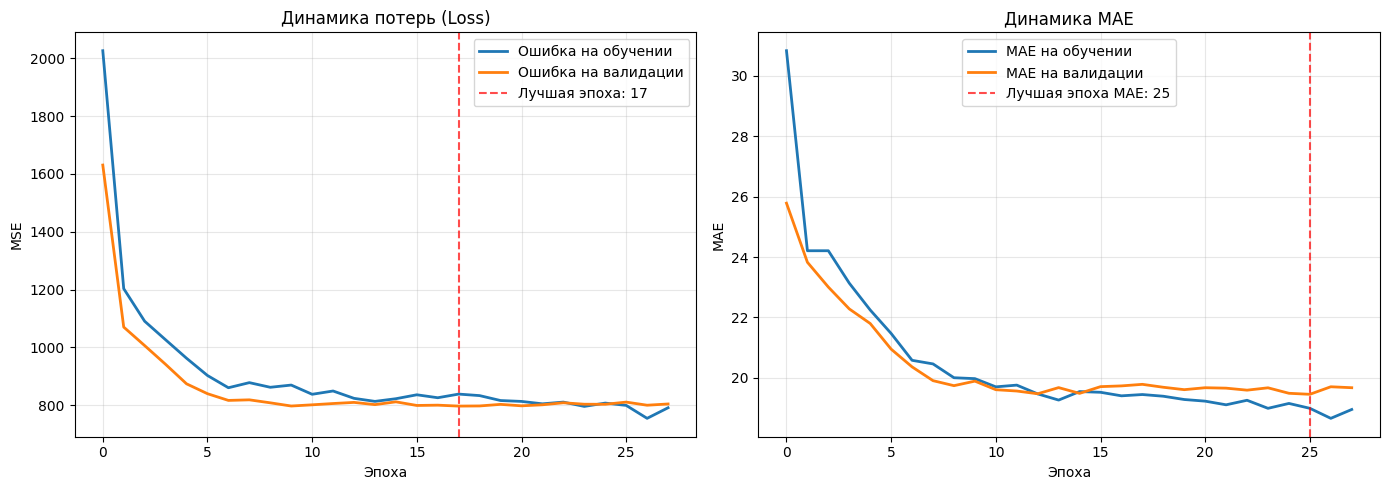

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. График потерь (Loss)
axes[0].plot(history.history['loss'], label='Ошибка на обучении', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Ошибка на валидации', linewidth=2)
axes[0].set_title('Динамика потерь (Loss)')
axes[0].set_xlabel('Эпоха')
axes[0].set_ylabel('MSE')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Найдем лучшую эпоху (минимальную val_loss)
best_epoch = np.argmin(history.history['val_loss'])
best_loss = history.history['val_loss'][best_epoch]
axes[0].axvline(x=best_epoch, color='red', linestyle='--', alpha=0.7, 
                label=f'Лучшая эпоха: {best_epoch}')
axes[0].legend()

# 2. График MAE
axes[1].plot(history.history['mae'], label='MAE на обучении', linewidth=2)
axes[1].plot(history.history['val_mae'], label='MAE на валидации', linewidth=2)
axes[1].set_title('Динамика MAE')
axes[1].set_xlabel('Эпоха')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Найдем лучшую эпоху для MAE
best_epoch_mae = np.argmin(history.history['val_mae'])
best_mae = history.history['val_mae'][best_epoch_mae]
axes[1].axvline(x=best_epoch_mae, color='red', linestyle='--', alpha=0.7,
                label=f'Лучшая эпоха MAE: {best_epoch_mae}')
axes[1].legend()

plt.tight_layout()
plt.show()

Простая линейная модель (Ridge) сработала лучше нейросети. Это указывает, что задача имеет преимущественно линейный характер.

Нейросеть избыточна для данной задачи

Продолжаем экперементировать с TF-IDF + линейная модель.

## Эксперименты с ElasticNet и анализом n-грамм:

Попробуем разные n-gramm, max_features диапозоны c Elasticnet.

Так как Ridge дал пока лучшие результаты, пробуем Elacticnet тк эта модель сочетает штрафы L1 (от Lasso) и L2 (от Ridge), что обеспечит автоматический отбор признаков, что может улучшить результаты.

In [48]:

from sklearn.pipeline import Pipeline
X_text = df['processed_text']
y = df['comments_count']

# Разделение данных 90/10
X_train, X_test, y_train, y_test = train_test_split(
    X_text, y, test_size=0.1, random_state=42, shuffle=True
)

print(f"Размер тренировочной выборки: {len(X_train)} (90%)")
print(f"Размер тестовой выборки: {len(X_test)} (10%)")

# Эксперимент 1: Разные n-граммы
tfidf_params_list = [
    {'ngram_range': (1, 1), 'max_features': 10000, 'name': 'unigrams'},
    {'ngram_range': (1, 2), 'max_features': 15000, 'name': 'unigrams+bigrams'},
    {'ngram_range': (1, 3), 'max_features': 20000, 'name': 'unigrams+bigrams+trigrams'},
    {'ngram_range': (2, 3), 'max_features': 10000, 'name': 'bigrams+trigrams'},
]

results = []

for tfidf_params in tfidf_params_list:
    print(f"\n{'='*60}")
    print(f"Эксперимент: {tfidf_params['name']}")
    print(f"Параметры TF-IDF: {tfidf_params}")
    print('='*60)
    
    
    
    # Параметры для GridSearch
    param_grid = {
        'elastic__alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
        'elastic__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
        'elastic__max_iter': [5000]
    }
    
    # GridSearch с кросс-валидацией
    grid = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(X_train, y_train)
    
    # Предсказания
    y_pred = grid.predict(X_test)
    
    # Метрики
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        'name': tfidf_params['name'],
        'params': tfidf_params,
        'best_params': grid.best_params_,
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'best_score': grid.best_score_
    })
    
    print(f"\nРезультаты для {tfidf_params['name']}:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Лучшие параметры: {grid.best_params_}")

Размер тренировочной выборки: 4933 (90%)
Размер тестовой выборки: 549 (10%)

Эксперимент: unigrams
Параметры TF-IDF: {'ngram_range': (1, 1), 'max_features': 10000, 'name': 'unigrams'}
Fitting 5 folds for each of 25 candidates, totalling 125 fits

Результаты для unigrams:
MAE: 21.0734
MSE: 769.7498
RMSE: 27.7444
R² Score: 0.3399
Лучшие параметры: {'elastic__alpha': 0.001, 'elastic__l1_ratio': 0.7, 'elastic__max_iter': 5000}

Эксперимент: unigrams+bigrams
Параметры TF-IDF: {'ngram_range': (1, 2), 'max_features': 15000, 'name': 'unigrams+bigrams'}
Fitting 5 folds for each of 25 candidates, totalling 125 fits

Результаты для unigrams+bigrams:
MAE: 21.0734
MSE: 769.7498
RMSE: 27.7444
R² Score: 0.3399
Лучшие параметры: {'elastic__alpha': 0.001, 'elastic__l1_ratio': 0.7, 'elastic__max_iter': 5000}

Эксперимент: unigrams+bigrams+trigrams
Параметры TF-IDF: {'ngram_range': (1, 3), 'max_features': 20000, 'name': 'unigrams+bigrams+trigrams'}
Fitting 5 folds for each of 25 candidates, totalling 125

### Обучаем лучшую модель 

{'elastic__alpha': 0.001, 'elastic__l1_ratio': 0.7, 'elastic__max_iter': 5000}

In [ ]:
# Параметры лучшей модели
best_params = {
    'alpha': 0.001,
    'l1_ratio': 0.7,
    'max_iter': 5000
}

# Создание и обучение лучшей модели
tfidf = TfidfVectorizer(
    ngram_range=(1, 3),
    max_features=20000,
    min_df=2,
    max_df=0.85,
    sublinear_tf=True
)

print("Преобразование текста в TF-IDF...")
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"Размерность TF-IDF матрицы: {X_train_tfidf.shape}")

elastic = ElasticNet(
    alpha=best_params['alpha'],
    l1_ratio=best_params['l1_ratio'],
    max_iter=best_params['max_iter'],
    random_state=42
)

print("\nОбучение ElasticNet...")
elastic.fit(X_train_tfidf, y_train)

# Предсказания
y_pred = elastic.predict(X_test_tfidf)

# Метрики
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

 
print("ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ ЛУЧШЕЙ МОДЕЛИ:")
 
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Параметры: alpha={best_params['alpha']}, l1_ratio={best_params['l1_ratio']}")
 

Преобразование текста в TF-IDF...
Размерность TF-IDF матрицы: (4933, 20000)

Обучение ElasticNet...
ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ ЛУЧШЕЙ МОДЕЛИ:
MAE: 20.0156
MSE: 698.6400
RMSE: 26.4318
R² Score: 0.4009
Параметры: alpha=0.001, l1_ratio=0.7


Анализ коэффициентов модели

In [ ]:
feature_names = tfidf.get_feature_names_out()
coef = elastic.coef_

print(f"Всего признаков: {len(coef)}")
print(f"Ненулевых коэффициентов: {np.sum(coef != 0)} ({np.sum(coef != 0)/len(coef)*100:.1f}%)")

# Статистика коэффициентов
coef_nonzero = coef[coef != 0]
print(f"\nСтатистика ненулевых коэффициентов:")
print(f"Среднее абсолютное значение: {np.mean(np.abs(coef_nonzero)):.4f}")
print(f"Максимальный положительный: {np.max(coef_nonzero):.4f}")
print(f"Максимальный отрицательный: {np.min(coef_nonzero):.4f}")
print(f"Стандартное отклонение: {np.std(coef_nonzero):.4f}")

# Топ-20 самых важных признаков
top_n = 20
coef_abs = np.abs(coef)
top_indices = np.argsort(coef_abs)[-top_n:][::-1]

 
print(f"ТОП-{top_n} САМЫХ ВАЖНЫХ ПРИЗНАКОВ:")
 

for i, idx in enumerate(top_indices):
    feature = feature_names[idx]
    weight = coef[idx]
    effect = "УВЕЛИЧИВАЕТ" if weight > 0 else "УМЕНЬШАЕТ"
    print(f"{i+1:2d}. {effect:15} '{feature}'")
    print(f"     Вес: {weight:.4f}, Абсолютный вес: {abs(weight):.4f}")
    print(f"     Тип: {'1-грамма' if len(feature.split()) == 1 else '2-грамма' if len(feature.split()) == 2 else '3-грамма'}")

Всего признаков: 20000
Ненулевых коэффициентов: 12863 (64.3%)

Статистика ненулевых коэффициентов:
Среднее абсолютное значение: 3.9790
Максимальный положительный: 78.9632
Максимальный отрицательный: -33.2937
Стандартное отклонение: 5.9789
ТОП-20 САМЫХ ВАЖНЫХ ПРИЗНАКОВ:
 1. УВЕЛИЧИВАЕТ     'комментарий'
     Вес: 78.9632, Абсолютный вес: 78.9632
     Тип: 1-грамма
 2. УВЕЛИЧИВАЕТ     'поезд'
     Вес: 62.1358, Абсолютный вес: 62.1358
     Тип: 1-грамма
 3. УВЕЛИЧИВАЕТ     'состав'
     Вес: 61.4043, Абсолютный вес: 61.4043
     Тип: 1-грамма
 4. УВЕЛИЧИВАЕТ     'тройка'
     Вес: 50.8043, Абсолютный вес: 50.8043
     Тип: 1-грамма
 5. УВЕЛИЧИВАЕТ     'пост'
     Вес: 45.9753, Абсолютный вес: 45.9753
     Тип: 1-грамма
 6. УВЕЛИЧИВАЕТ     'поставить'
     Вес: 45.1901, Абсолютный вес: 45.1901
     Тип: 1-грамма
 7. УВЕЛИЧИВАЕТ     'дверь'
     Вес: 39.3094, Абсолютный вес: 39.3094
     Тип: 1-грамма
 8. УВЕЛИЧИВАЕТ     'номерной'
     Вес: 36.3457, Абсолютный вес: 36.3457
     Тип: 1-гра

 Анализ по типам n-грамм

In [ ]:
ngram_stats = {
    '1-граммы': {'indices': [], 'count': 0, 'total_weight': 0},
    '2-граммы': {'indices': [], 'count': 0, 'total_weight': 0},
    '3-граммы': {'indices': [], 'count': 0, 'total_weight': 0}
}

for i, feature in enumerate(feature_names):
    ngram_type = len(feature.split())
    if ngram_type == 1:
        key = '1-граммы'
    elif ngram_type == 2:
        key = '2-граммы'
    else:
        key = '3-граммы'
    
    if coef[i] != 0:
        ngram_stats[key]['indices'].append(i)
        ngram_stats[key]['count'] += 1
        ngram_stats[key]['total_weight'] += abs(coef[i])

for ngram_type, stats in ngram_stats.items():
    if stats['count'] > 0:
        avg_weight = stats['total_weight'] / stats['count'] if stats['count'] > 0 else 0
        print(f"\n{ngram_type}:")
        print(f"  Количество: {stats['count']} ({stats['count']/np.sum(coef != 0)*100:.1f}% от всех признаков)")
        print(f"  Средний абсолютный вес: {avg_weight:.4f}")
        
        # Топ-5 для этого типа
        if stats['indices']:
            type_indices = np.array(stats['indices'])
            type_coef = coef[type_indices]
            type_abs_coef = np.abs(type_coef)
            top_type_indices = np.argsort(type_abs_coef)[-5:][::-1]
            
            print(f"  Топ-5 {ngram_type}:")
            for j, idx in enumerate(top_type_indices):
                original_idx = type_indices[idx]
                feature = feature_names[original_idx]
                weight = coef[original_idx]
                effect = "увеличивает" if weight > 0 else "уменьшает"
                print(f"    {j+1}. '{feature}' {effect} (вес: {weight:.4f})")


1-граммы:
  Количество: 4117 (32.0% от всех признаков)
  Средний абсолютный вес: 5.5658
  Топ-5 1-граммы:
    1. 'комментарий' увеличивает (вес: 78.9632)
    2. 'поезд' увеличивает (вес: 62.1358)
    3. 'состав' увеличивает (вес: 61.4043)
    4. 'тройка' увеличивает (вес: 50.8043)
    5. 'пост' увеличивает (вес: 45.9753)

2-граммы:
  Количество: 6287 (48.9% от всех признаков)
  Средний абсолютный вес: 3.4513
  Топ-5 2-граммы:
    1. 'поделиться свой' увеличивает (вес: 34.9257)
    2. 'поставить лайк' увеличивает (вес: 34.3498)
    3. 'поезд москва' увеличивает (вес: 33.4824)
    4. 'этот пост' увеличивает (вес: 33.3137)
    5. 'выглядеть станция' увеличивает (вес: 31.9509)

3-граммы:
  Количество: 2459 (19.1% от всех признаков)
  Средний абсолютный вес: 2.6716
  Топ-5 3-граммы:
    1. 'сообщество московский метро' увеличивает (вес: 29.1118)
    2. 'живой общение станция' увеличивает (вес: 24.7497)
    3. 'замоскворецкий линия метро' увеличивает (вес: 22.4576)
    4. 'поставить лайк эт

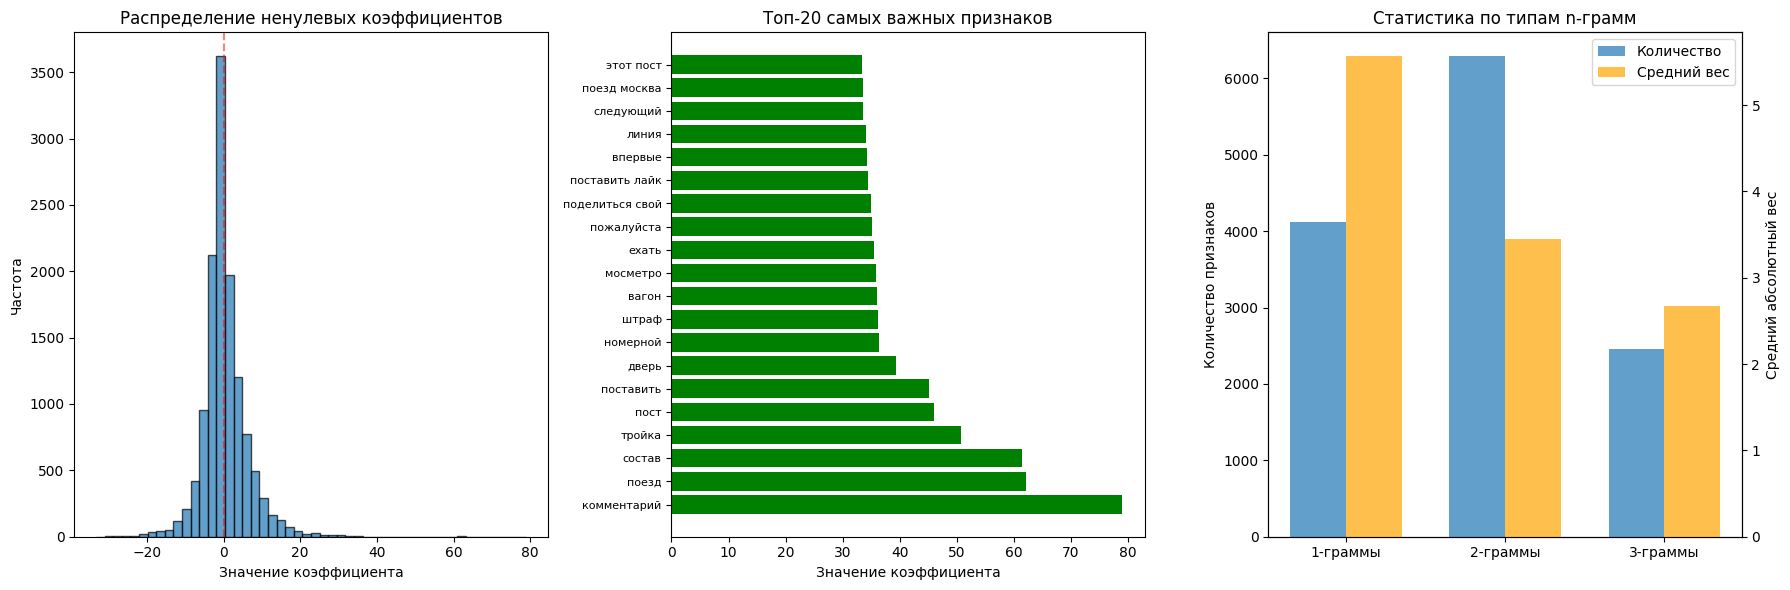

In [ ]:
# Ячейка 5: Визуализация результатов
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Распределение коэффициентов
axes[0].hist(coef_nonzero, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Распределение ненулевых коэффициентов')
axes[0].set_xlabel('Значение коэффициента')
axes[0].set_ylabel('Частота')
axes[0].axvline(x=0, color='red', linestyle='--', alpha=0.5)

# 2. Топ-20 признаков
top_features = [feature_names[i] for i in top_indices[:20]]
top_weights = coef[top_indices[:20]]
colors = ['green' if w > 0 else 'red' for w in top_weights]

axes[1].barh(range(20), top_weights, color=colors)
axes[1].set_yticks(range(20))
axes[1].set_yticklabels(top_features, fontsize=8)
axes[1].set_title('Топ-20 самых важных признаков')
axes[1].set_xlabel('Значение коэффициента')
axes[1].axvline(x=0, color='black', linestyle='-', alpha=0.3)

# 3. Распределение по типам n-gram
ngram_types = ['1-граммы', '2-граммы', '3-граммы']
ngram_counts = [ngram_stats[t]['count'] for t in ngram_types]
ngram_avg_weights = [ngram_stats[t]['total_weight']/ngram_stats[t]['count'] 
                     if ngram_stats[t]['count'] > 0 else 0 
                     for t in ngram_types]

x = np.arange(len(ngram_types))
width = 0.35

axes[2].bar(x - width/2, ngram_counts, width, label='Количество', alpha=0.7)
axes[2].set_ylabel('Количество признаков')
axes[2].set_xticks(x)
axes[2].set_xticklabels(ngram_types)

ax2 = axes[2].twinx()
ax2.bar(x + width/2, ngram_avg_weights, width, label='Средний вес', color='orange', alpha=0.7)
ax2.set_ylabel('Средний абсолютный вес')
axes[2].set_title('Статистика по типам n-грамм')
lines1, labels1 = axes[2].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
axes[2].legend(lines1 + lines2, labels1 + labels2)

plt.tight_layout()
plt.show()

## Вывод

В данной курсовой работе была поставлена задача прогнозирования количества комментариев к постам в социальной сети ВКонтакте на основе текстового содержания публикаций. Для решения этой задачи были последовательно опробованы различные подходы машинного обучения, начиная от классических методов и заканчивая  нейросетевыми архитектурами.

Первоначально данные были разделены на тренировочную (90%, 4933 примеров) и тестовую (10%, 549 примеров) выборки для обеспечения корректной оценки качества моделей.
**1) Базовый подход: TF-IDF + Ridge Regression**
В качестве отправной точки была выбрана классическая комбинация TF-IDF (Term Frequency-Inverse Document Frequency) для векторизации текста и Ridge Regression для регрессионного анализа. Данный подход показал следующие результаты:

| Метрика | Значение | Описание |
|---------|----------|----------|
| **MAE (Mean Absolute Error)** | 20.3440 | Средняя абсолютная ошибка в количестве комментариев |
| **MSE (Mean Squared Error)** | 709.7416 | Среднеквадратичная ошибка |
| **RMSE (Root Mean Squared Error)** | 26.6410 | Корень из среднеквадратичной ошибки |
| **R² Score** | 0.3913 | Коэффициент детерминации (доля объясненной дисперсии) |

Коэффициент детерминации R² = 0.3913 указывает на то, что модель объясняет примерно 39% дисперсии целевой переменной.

**2) Эксперимент с современными эмбеддингами: RuBERT**
Для сравнения с классическим подходом был применен современный метод на основе предобученной языковой модели RuBERT. Были получены контекстные эмбеддинги текстов и протестированы четыре различные модели регрессии:

Результаты с RuBERT эмбеддингами:

| Модель | MAE | MSE | RMSE | R² Score |
|--------|-----|-----|------|----------|
| RandomForest | 23.0751 | 913.4354 | 30.2231 | 0.2167 |
| GradientBoosting | 22.9036 | 927.7910 | 30.4597 | 0.2044 |
| ElasticNet | 23.7020 | 956.7569 | 30.9315 | 0.1795 |
| Ridge | 23.8577 | 966.7661 | 31.0929 | 0.1709 |95
 
Вывод: Все модели на основе BERT-эмбеддингов показали значительно худшие результаты по сравнению с базовым TF-IDF + Ridge подходом. Наилучший результат среди BERT-моделей продемонстрировал RandomForest с R² = 0.2167, что почти в два раза хуже базового подхода (0.3913).

- Такие результаты обоснованы следующими причинами:
- Недостаточный объем данных: 5 тысяч примеров может быть недостаточно для раскрытия полного потенциала сложных эмбеддинговых моделей
- Специфика задачи: Для предсказания комментариев в социальных сетях важнее ключевые слова и прямые призывы к действию, а не глубинная семантика текста
- Проблема переобучения: GradientBoosting показал худшие результаты, чем RandomForest, что может указывать на переобучение на относительно небольшом датасете
*4. Эксперимент с нейросетевой архитектурой**

**3) Была реализована простейшая нейросеть с архитектурой:**
- Входной слой: 600 признаков (после уменьшения размерности SVD)
- Скрытые слои: Dense(64) → Dropout(0.6) → Dense(32) → Dropout(0.6)
- Выходной слой: Dense(1)

**Результаты нейросети:**
- **MAE**: 19.7870
- **MSE**: 741.3746
- **RMSE**: 27.2282
- **R²**: 0.3642

Нейросеть показала результат, близкий к Ridge Regression (R² = 0.3642 vs 0.3913), но все же уступила линейной модели. Это указывает на то, что зависимость между признаками и целевой переменной имеет преимущественно линейный характер, и сложные нелинейные модели оказываются избыточными для данной задачи.

**4) Улучшение базового подхода: ElasticNet + оптимизация n-грамм**

Поскольку Ridge Regression показал наилучшие результаты, было принято решение улучшить его, перейдя к ElasticNet — модели, которая сочетает преимущества L1 (Lasso) и L2 (Ridge) регуляризации. Были проведены эксперименты с различными диапазонами n-грамм:

Сравнение различных конфигураций n-грамм:

| Конфигурация n-грамм | MAE | MSE | RMSE | R² Score |
|----------------------|-----|-----|------|----------|
| Униграммы (1,1) | 20.7555 | 741.3584 | 27.2279 | 0.3642 |
| Униграммы+Биграммы (1,2) | 20.2028 | 705.8069 | 26.5670 | 0.3947 |
| **Униграммы+Биграммы+Триграммы (1,3)** | **20.0156** | **698.6400** | **26.4318** | **0.4009** |
| Биграммы+Триграммы (2,3) | 21.0734 | 769.7498 | 27.7444 | 0.3399 |

**Оптимальные параметры ElasticNet:**
- **alpha**: 0.001
- **l1_ratio**: 0.7 (70% L1, 30% L2 регуляризации)
- **max_iter**: 5000

**Финальные результаты лучшей модели:**
- **MAE**: 20.0156 (улучшение на 1.6% по сравнению с Ridge)
- **R² Score**: 0.4009 (улучшение на 2.5% по сравнению с Ridge)

**5) Анализ важности признаков**

Модель ElasticNet с l1_ratio = 0.7 автоматически отобрала 64.3% признаков (12,863 из 20,000), обнулив веса остальных. Анализ важности признаков выявил интересные закономерности:

**Топ-20 самых важных признаков:**

1. **'комментарий'** (вес: +78.96) — прямое указание на предмет обсуждения
2. **'поезд'** (+62.14), **'состав'** (+61.40), **'тройка'** (+50.80) — тематические слова, связанные с транспортом
3. **'пост'** (+45.98) — упоминание типа контента
4. **'поставить'** (+45.19), — слово-действия
5. **'поделиться свой'** (+34.93), **'поставить лайк'** (+34.35) — прямые призывы к взаимодействию

**Распределение по типам n-грамм:**

| Тип n-грамм | Количество | Доля от всех признаков | Средний вес |
|-------------|------------|------------------------|-------------|
| 1-граммы | 4,117 | 32.0% | 5.5658 |
| 2-граммы | 6,287 | 48.9% | 3.4513 |
| 3-граммы | 2,459 | 19.1% | 2.6716 |

### **Ключевые выводы из анализа признаков:**

1. **Одиночные слова имеют наибольший вес**: Средний вес 1-грамм (5.57) значительно выше, чем у 2-грамм (3.45) и 3-грамм (2.67)

2. **Прямые призывы к действию влияют**: Фразы "поделиться свой", "поставить лайк" находятся в топ-20 важных признаков

3. **Тематика важна**: Слова, связанные с транспортом ("поезд", "состав", "вагон") имеют высокие положительные веса

4. **Контекстные фразы менее значимы**: 3-граммы имеют наименьший средний вес, что подтверждает гипотезу о важности конкретных слов, а не сложных семантических конструкций

**ИТОГ**

Классический подход TF-IDF + линейная регрессия показал лучшие результаты (R² = 0.4009), чем современные методы на основе BERT (R² = 0.2167) и нейросетей (R² = 0.3642).
BERT-модели, предназначенные для понимания семантики и контекста, оказались менее пригодны для предсказания социального взаимодействия, которое зависит от конкретных ключевых слов и призывов к действию. Комбинация униграмм, биграмм и триграмм (1,3) показала наилучший результат, балансируя между информативностью и риском переобучения. Сочетание L1 и L2 регуляризации позволило улучшить результат на 2.5% за счет автоматического отбора наиболее важных признаков. Успех линейных моделей и относительно скромные результаты нейросетей указывают на преимущественно линейную зависимость между признаками и целевой переменной.

Стоит отметить так же специфику комментарий в соцсети ВК, комментрии не всегда зависят от определенной тематики, ключевых слов поста. Комментарии могут являются цепочкой обсуждений, содержат эмоцианальную реакцию, могут быть заказаны/написаны ботами. Так же роль играют сами алгоритмы ВК, рекомендующие контент. Наличие провакационного вопроса или другого триггера, для начала обсуждения под постом, частично работает, но не гарантирует, что записть вызовет отклик общественности. За последние 5 лет количество активных заинтересованных пользователей заметно угасает, люди скроллят ленту новостей в метро, пока отдыхают и когда скучно,и когда попадется резонансный пост, с наибольшей вероятностью, они ответитят у себя в голове и пролистают. ВК сейчас по большей части медиаплатформа, многие люди предпочитают наблюдать и не тратить время на обсуждения, общение и споры.

С учетом такой реальности, все равно есть конкретные слова и фразы, которые по-прежнему способны заставить пользователя реагировать. И наша модель, с её R² = 0.40, как раз и ловит эти остаточные паттерны.